In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
import theano.tensor as T
import scipy.stats as stats
from scipy.interpolate import griddata

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**4.1**
* Noram Distribution by adding

Any process that adds together random variables from the same distribution (uniform in this case) converges to a normal distribution.

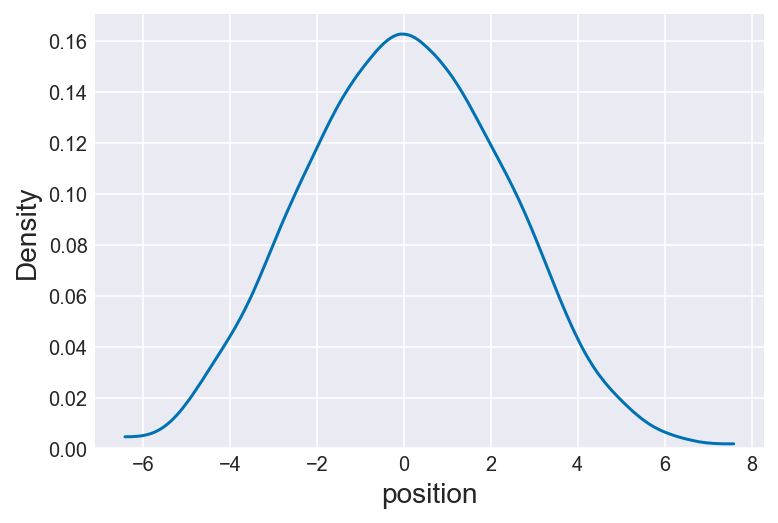

In [34]:
"""For each person out of 1000, we generate 16 random numbers (steps) from -1 (meter backwards) to 1 (meter forwards). \
We use sum(0) to add these steps together to get their position after 16 steps"""

pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
pm.kdeplot(pos)
plt.xlabel('position', fontsize=14)
plt.ylabel('Density', fontsize=14);

**4.2, 4.3**
* Noram Distribution by multiplication

Any process that has small effects of multiplication is approximately additive; thus, it would also tend to converge to a normal distribution.

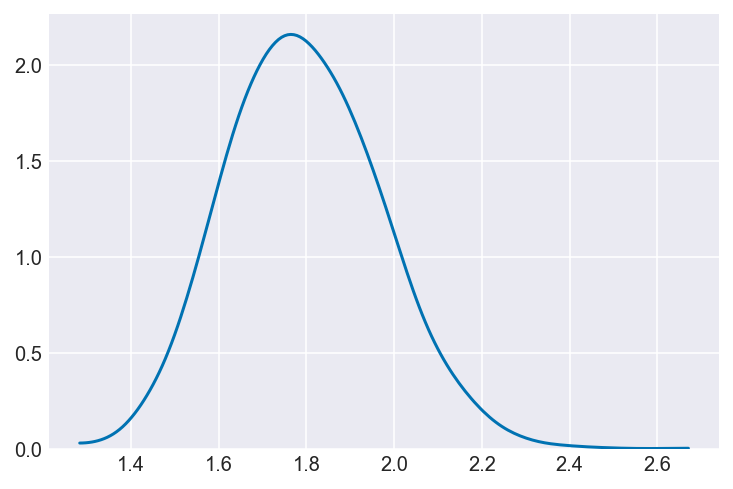

In [31]:
pos  =  np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
pm.kdeplot(pos);

**4.4**

But large effects of multiplication won't necessarily converge to a Gaussian. See the difference below:

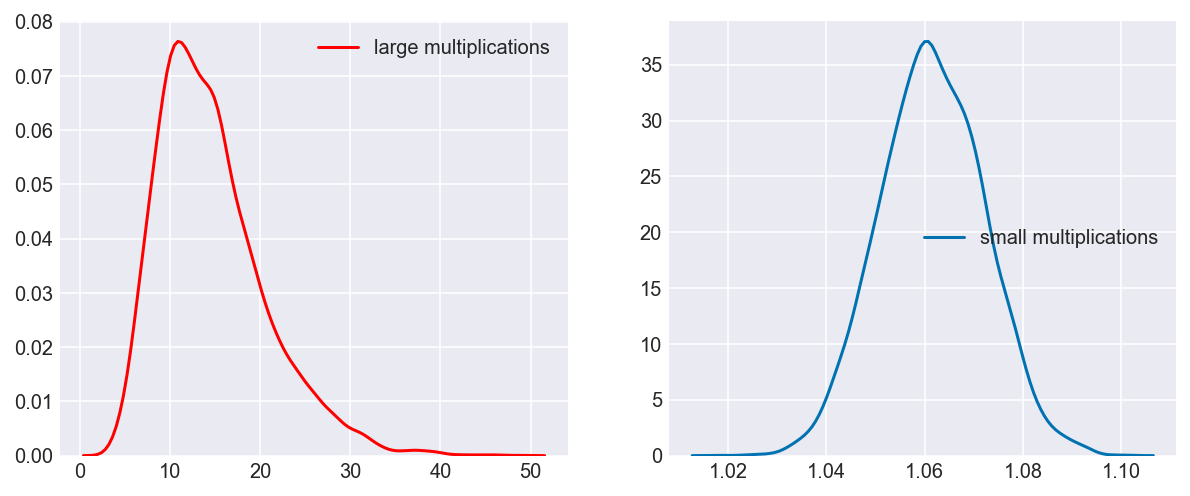

In [41]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(10,4))
sns.kdeplot(big, ax=ax[0], label='large multiplications', color='red')
sns.kdeplot(small, ax=ax[1], label='small multiplications')
plt.legend()
plt.show()

**4.5**

* Normal distribution by Log multiplication

Large deviations that are multiplied together don't produce a Gaussian distribution, but their log scale does tend to produce a Gaussian. 

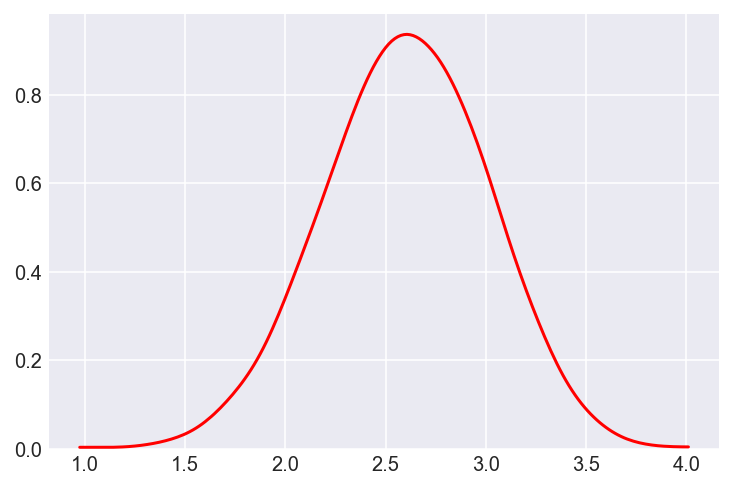

In [45]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
pm.kdeplot(log_big, color='red')
plt.show()

**4.7, 4.8**

In [14]:
d = pd.read_csv('Data/Howell1.txt', sep=';')
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

**4.9**

In [16]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

**4.10**

In [18]:
d2 = d[d.age>18]

# The Model

* h1 ~ Normal(μ,σ) (likelihood of height)
* μ  ~ Normal(178,20) (prior)
* σ  ~ Uniform(0,50) (prior)

**4.11**

Plot the prior of μ to get a sense of how it's built into the model

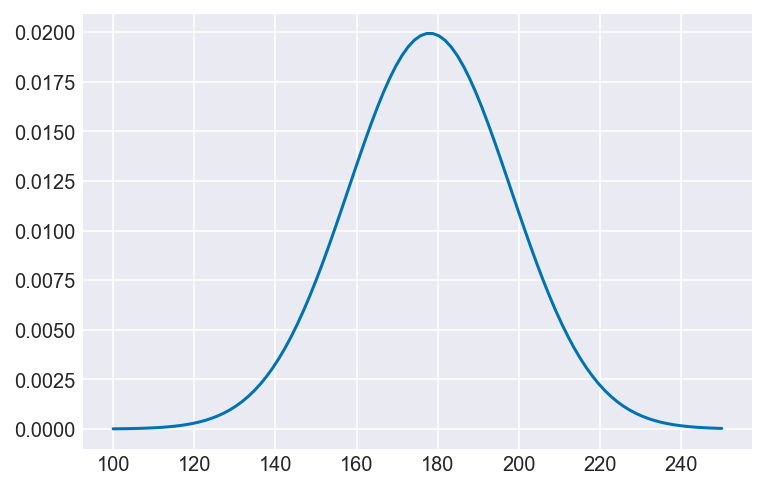

With chosen parameters, we see a 95% probability between 178+-40


In [67]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20))
plt.show()
print("With chosen parameters, we see a 95% probability between 178+-40")

**4.12**

Plot the prior of σ to get a sense of how it's built into the model

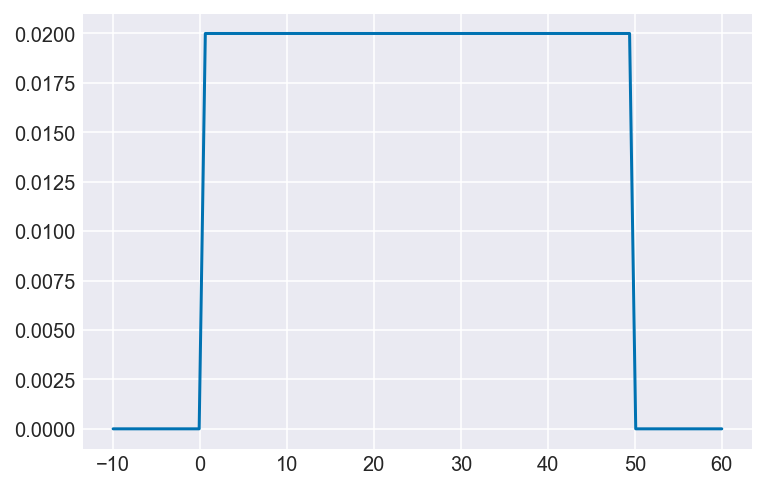

In [26]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

**4.13**
* simulate the prior heights

With these priors, we now have a prior distribution of individual heights, before having looked at the data. In order to simulate these heights, we can sample from the prior:

Notice that the probability distribution is not a Gaussian. This is ok because the distribution is not an empirical expectation, but rather the distribution of relative plausibilities of different heights, before seeing the data.


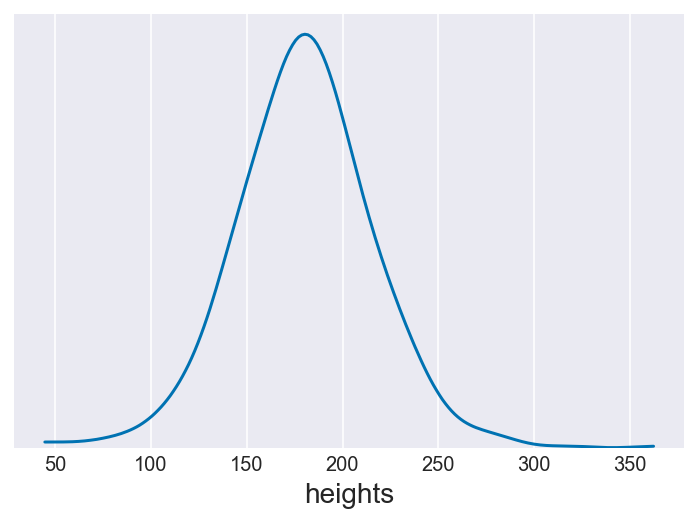

In [31]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
pm.kdeplot(prior_h)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);
print("Notice that the probability distribution is not a Gaussian. This is ok because the distribution is not an \
empirical expectation, but rather the distribution of relative plausibilities of different heights, \
before seeing the data.")

# Grid Approximation of the posterior distribution
**4.14**

Combining the prior with the data of heights and averaging over the posterior. 

In [32]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

**4.15, 4.16**

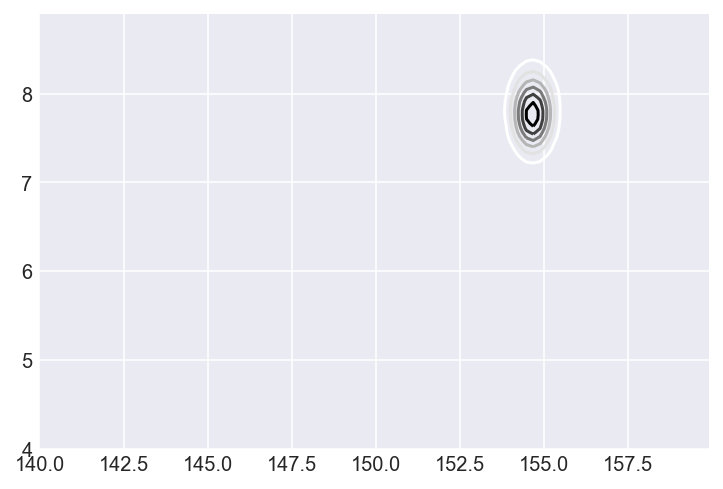

In [36]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

**4.17, 4.18**

Sample parameters from the posterior distribution

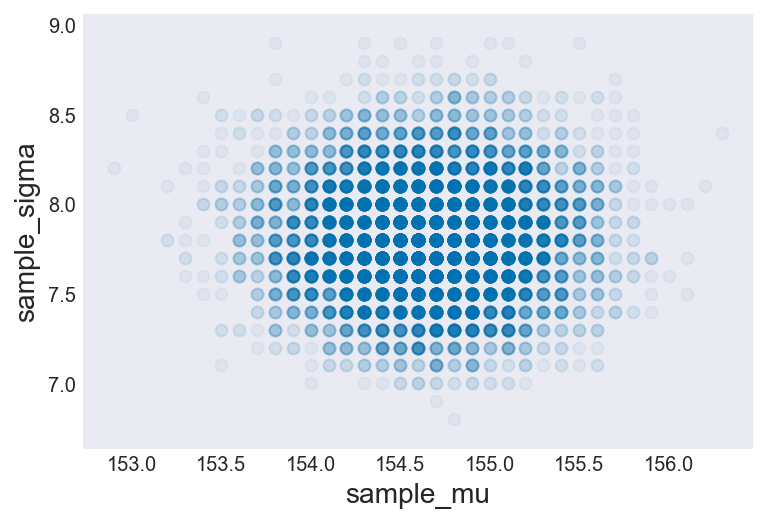

In [38]:
sample_rows  = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu', fontsize=14)
plt.ylabel('sample_sigma', fontsize=14);

**4.19**

Now that we have samples, we can describe the distribution of confidence in each parameter. Let's see the shape of the posterior of each parameter:

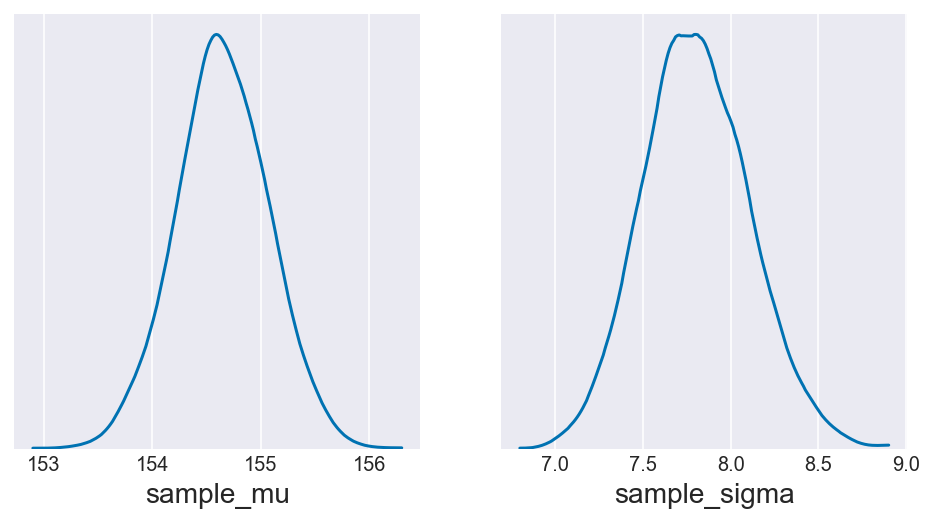

In [39]:
_, ax = plt.subplots(1,2, figsize=(8,4))
pm.kdeplot(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu', fontsize=14)
ax[0].set_yticks([])
pm.kdeplot(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma', fontsize=14)
ax[1].set_yticks([]);

**4.20**

Summarize the width of these densities:

In [43]:
pm.hpd(sample_mu), pm.hpd(sample_sigma) #default is 95%

(array([153.8, 155.4]), array([7.3, 8.4]))

**4.21, 4.22**

In [60]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod2 = (likelihood + 
              stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
              stats.uniform.logpdf(post[:,1], loc=0, scale=50))

post_prob2 = np.exp(post_prod - max(post_prod))

sample_rows2 = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu2 = post[:,0][sample_rows]
sample_sigma2 = post[:,1][sample_rows]

**4.23**

We see an that the posterior σ is less of a Gaussian when sample size is small, and it tends to have a long right-hand tail. This is not a problem that the mean would have because the posterior of the mean is always Gaussian, no matter the sample size. 

This problem occures because variance in a Normal distribution must be positive (starting at 0); consequently, there is more uncertainty about how big the variance is as opposed to how small. 

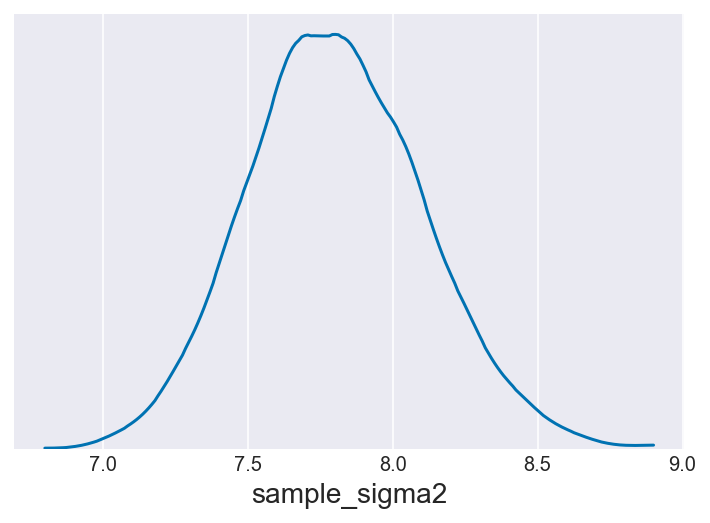

In [62]:
pm.kdeplot(sample_sigma2)
plt.xlabel('sample_sigma2', fontsize=14)
plt.yticks([]);

# Quadratic Approximation (MAP)
* h1 ~ Normal(μ,σ) (likelihood of height)
* μ  ~ Normal(178,20) (prior)
* σ  ~ Uniform(0,50) (prior)

**4.24**

In [5]:
d = pd.read_csv('Data/Howell1.txt', sep=';')
d2 = d[d.age>18]

**4.25**

In [65]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    #likelihood of height combined with data. I.E. what is the data, given the mu and sd parameteres
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height) 

**4.26**

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variables (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN 'jitter+adapt_diag', which starts by identifying the mass matrix and then adapting a diagonal based on the variance of the tuning samples.

In [84]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mu]


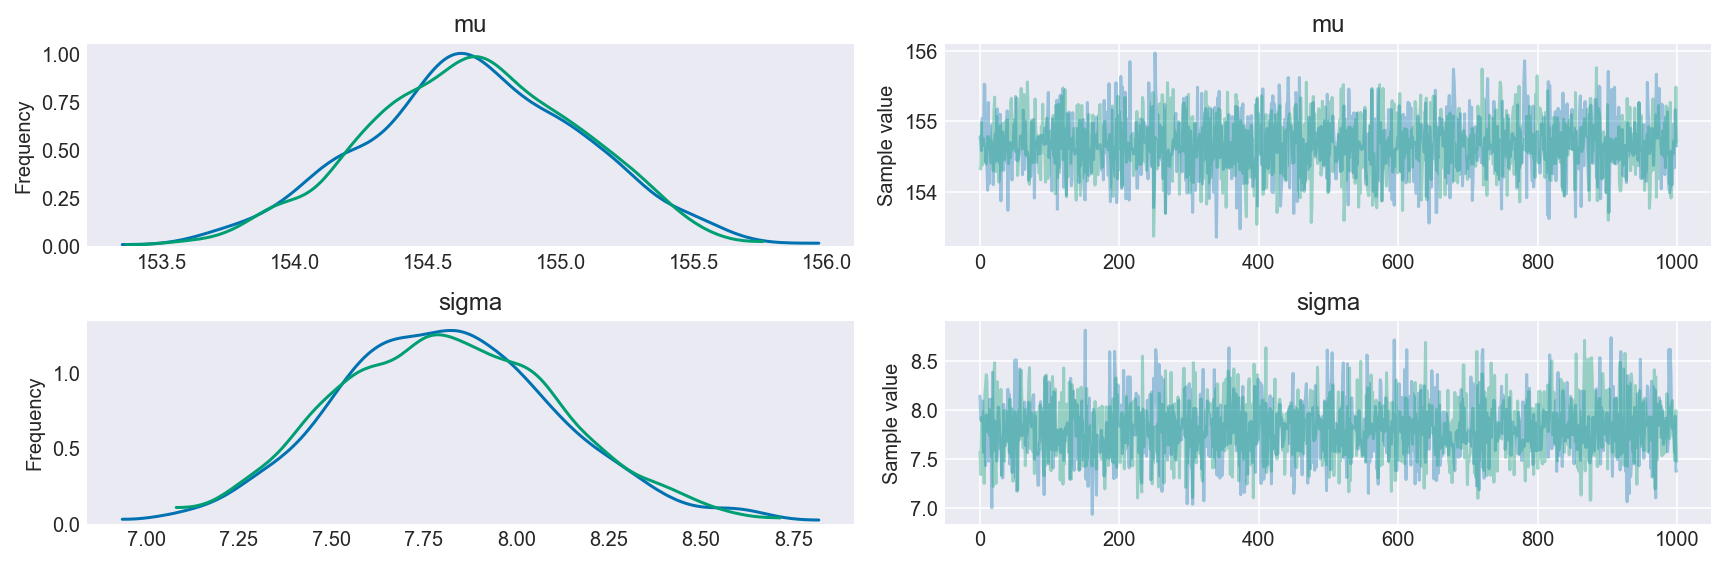

In [71]:
pm.traceplot(trace_4_1); # this function let you check the samples values

**4.27**
* 89% posterior interval

Notice that comapred to the table in the book we have an extra column, "mc_error". Since we are sampling from the posterior, there is an error introducing by the sampling process. This error can be reduced by taking more samples

In [85]:
# The 5.5% and the 94.5% quantiles are percentile interval boundaries, corresponding to an 89% posterior interval. 
# Most Bayesians use 95%, but the author recommends against that, because people get that confused with significance test 
pm.summary(trace_4_1, alpha=0.11) 

mean        sd  mc_error     hpd_5.5    hpd_94.5        n_eff  \
mu     154.654811  0.434052  0.008757  154.014218  155.364631  2125.120306   
sigma    7.798013  0.296241  0.007057    7.365644    8.293553  1832.976766   

           Rhat  
mu     0.999631  
sigma  1.000035

**4.28**
* Setting start values

We can help the sampler by setting a starting value for the prior's parameter. This represents a rough location of where the heighest posterior probability would sit. 

In [81]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mu]


mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
mu     154.66  0.43      0.01   153.95    155.28  1921.36   1.0
sigma    7.82  0.30      0.01     7.35      8.29  1629.64   1.0

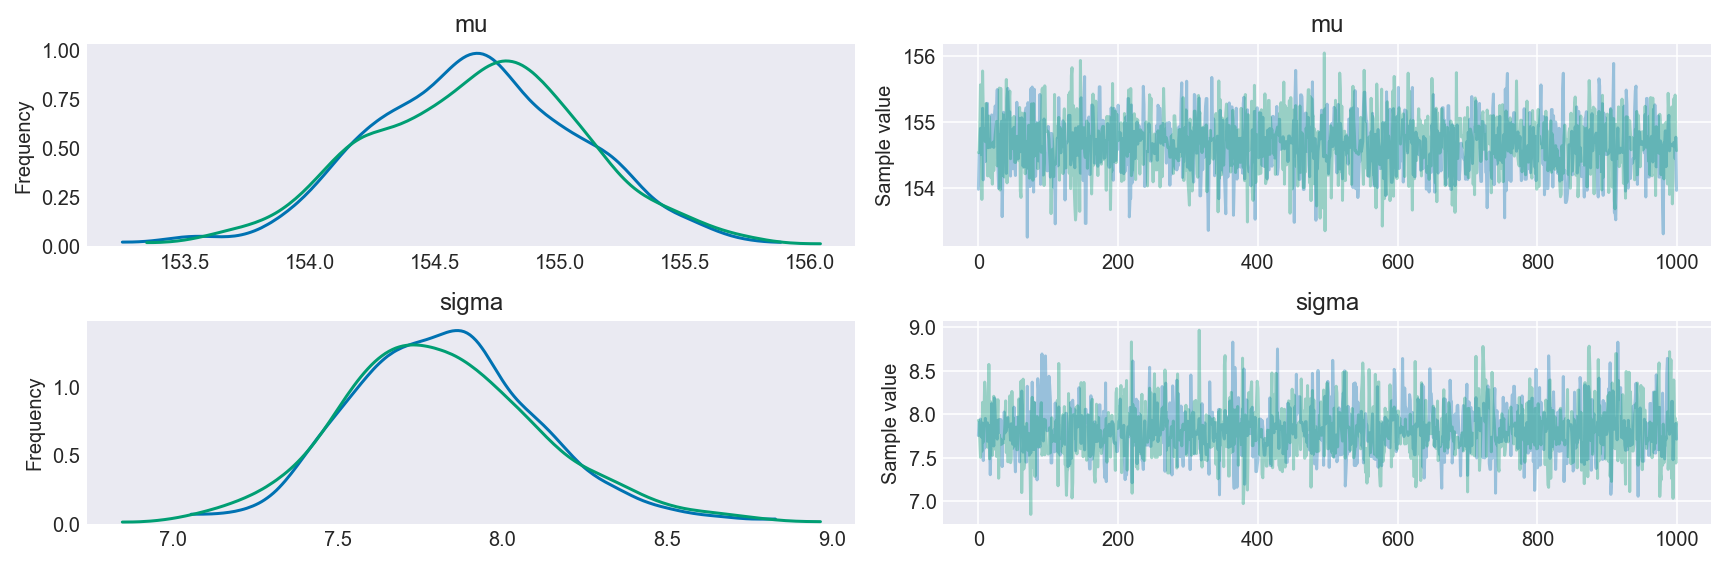

In [82]:
pm.traceplot(trace_4_1); 
pm.summary(trace_4_1, alpha=.11).round(2)

**4.29**

* More informative prior

The parameters for the prior μ that we used before was very weak N(178,20), so we'll create a more informative/narrow prior N(178,0.1)

In [86]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mu]


In [87]:
pm.summary(trace_4_2, alpha=.11).round(4)

mean      sd  mc_error   hpd_5.5  hpd_94.5      n_eff    Rhat
mu     177.8680  0.0971    0.0021  177.7137  178.0230  1903.5422  0.9997
sigma   24.5999  0.9477    0.0252   23.1413   26.0958  1810.1656  0.9995

Notice that the mean is 177.8 instead of 154 in the other model with prior (178,20). And the std is now 24 instead of 7. This is because once the model is certain that the mean is near 178 (as the prior insists), then the model has to estimate the σ conditional on that fact. 

**Side note:**

There is a simple formula for the standard deviation of a Gaussian posterior for μ, which allows us to compute the implied amount of data. In μ ~ Normal(178,0.1) the posterior sigma is:
$$σPosterior = \frac{1}{\sqrt n}$$ With some algebra, this turns out to: $$\sqrt n=\frac{1}{σPosterior}$$ Which is: 
$$n=\frac{1}{σPosterior^2}$$ Which computes as:
$$n=\frac{1}{0.1^2}=100$$
So this means that μ ~ Normal(178,0.1) is equivalent to having previously observed 100 heights with mean value 178. That's a pretty strong prior. 

In contrast, the prior (178,20) is weak because it is equivalent to having observed 0.0025 heights with mean value 178. That's a lot of uncertainty.

**4.30**
* Covariance

For some computations it could be nice to have the trace turned into a DataFrame, this can be donde using the "trace_to_dataframe" function.

In [88]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

mu     sigma
mu     0.188495  0.001708
sigma  0.001708  0.087803

Above is the Variance-Covariance matrix. It tells us how each parameter relates to every other parameter in the posterior distribution.

**4.31**

In [93]:
np.diag(trace_df.cov())

array([0.18849513, 0.08780272])

Above is the two-element vector in the list of variances. If you take the square root of these vectors, you get the standard deviation that is present in pm.summary.

In [89]:
trace_df.corr()

mu     sigma
mu     1.000000  0.013273
sigma  0.013273  1.000000

Above is the correlation between the parameters. It indicates that learning μ tells us nothing about σ and vice versa. But in many cases there is a correlation. We'll see those in future chapters.

**4.32**

(We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like this).

In [121]:
trace_df.head()

mu     sigma
0  154.341520  7.841384
1  153.903021  7.909135
2  153.848396  7.270842
3  153.836428  7.072908
4  154.282445  8.774512

Or directly from the trace (we are getting the first ten samples of sigma)

In [95]:
trace_4_1['sigma'][:10]

array([7.84138364, 7.90913511, 7.2708425 , 7.07290805, 8.77451184,
       8.05531707, 7.64881015, 7.64881015, 7.64881015, 7.92209173])

**4.33**

In our case, this is the same we did in the code 4.27

In [97]:
pm.summary(trace_4_1, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
mu     154.65  0.43      0.01   154.01    155.36  2125.12   1.0
sigma    7.80  0.30      0.01     7.37      8.29  1832.98   1.0

**4.35, 4.36**

* Lognormal: getting sigma right with the lognormal

Instead of sampling from a normal and then exponentiating to ensure sigma is positive (like done in the book), we can use the lognormal distribution for the same result. The Lognormal distribution is parametrized in terms of $\tau$ (tau) the precision and not the standard deviation, where:

$$tau=\frac{1}{sd^2}$$
The normal distribution can also be parametrized in terms of the precision (tau). Given that the conversion between both parametrization is done right, which one to use is only a matter of convenience.

**The use of Lognormal to effectively constrain a parameter to be positive is a robust and common one.**

**To use the logarithm rather than the standard deviation itself, we often get a better approximation of the uncertainty.**

In [134]:
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01) # using lognormal instead of Normal or uniform distributions
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, mu]


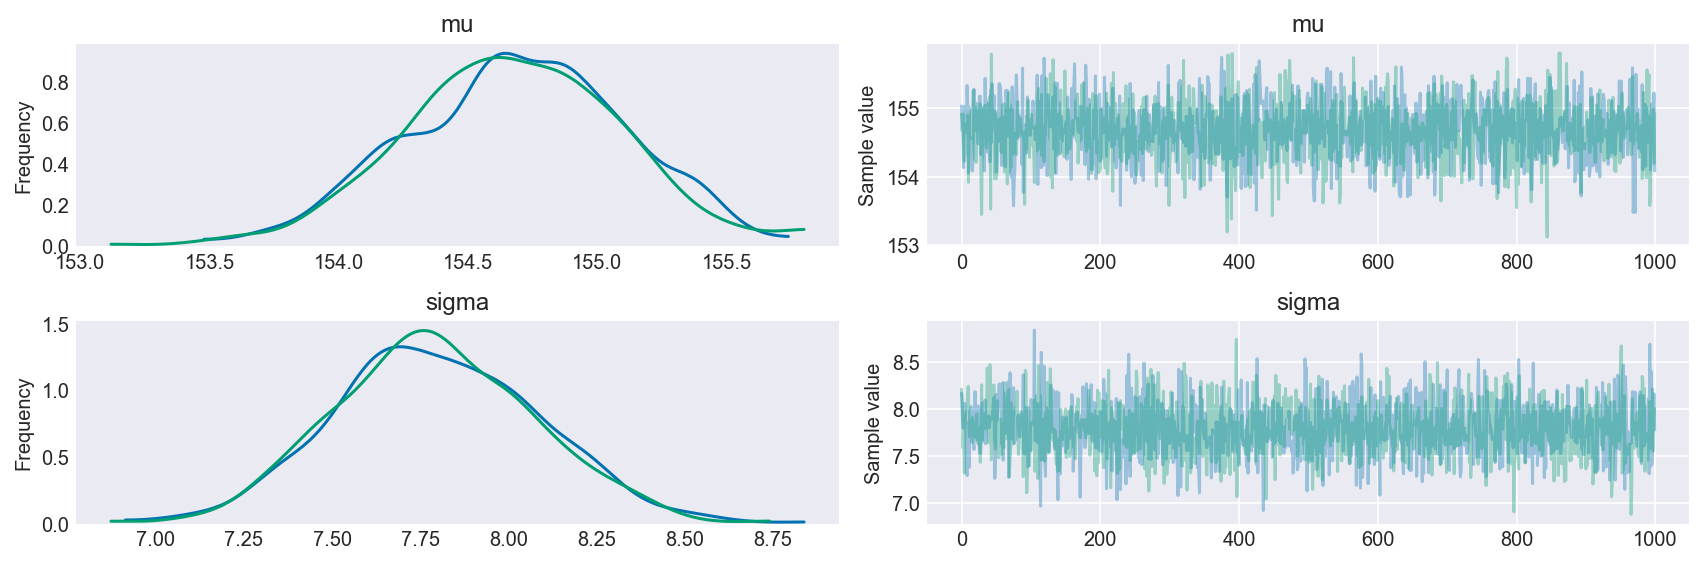

In [135]:
pm.traceplot(trace_4_1_logsigma);

In [136]:
pm.summary(trace_4_1_logsigma)

mean        sd  mc_error     hpd_2.5    hpd_97.5        n_eff  \
mu     154.672008  0.419654  0.009622  153.874055  155.487516  2100.934098   
sigma    7.789455  0.284288  0.005802    7.273392    8.356864  2029.612670   

           Rhat  
mu     1.000223  
sigma  0.999847

# Regression (Adding a Predictor)
**4.37**

Plotting height and weight against one another to see how strongly they covary.

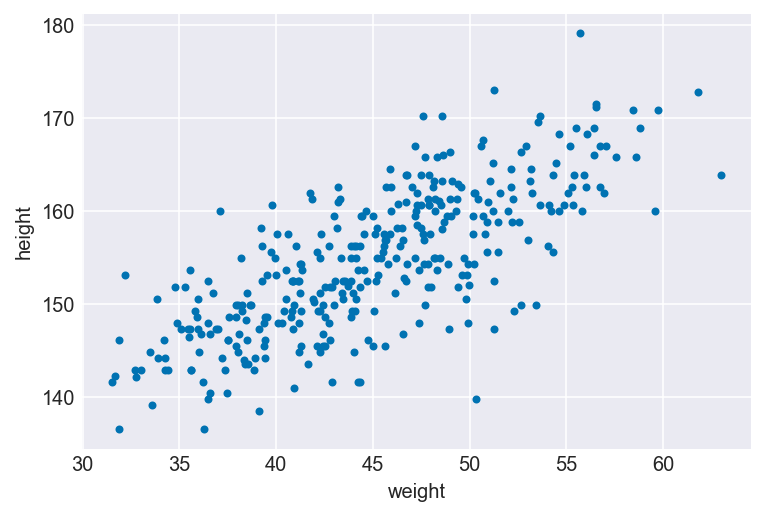

In [202]:
plt.plot(d2.weight, d2.height, '.')
plt.xlabel("weight")
plt.ylabel("height");

\begin{aligned}
h_i &\sim Normal(μ,σ)\\
μ_i &= α+βx_i\\
α &\sim Normal(178,100)\\
β &\sim Normal(0,10)\\
σ &\sim Uniform(0,50)
\end{aligned}

* μ is deterministic 
* x is the predictor (Weight)
* α is the intercept, indicating the expected height for every xi. (it has a large std because it is common for the intercept in a linear model to swing a long way from the mean of the outcome variable).
* β is the slope, inidicating the change in height when xi changes by 1 unit. (a zero mean suggests equal probability that the relationship between height and weight is negative or positive. It doesn't make sense here, but it's harmless because there is a lot of data).
* σ a large prior (50) will allow it the needed flexibility in the posterior distribution stage

**4.38, 4.39**

Notice that the variable mu is defined as alpha + beta \* d2.weight in a single line. **If we want the trace to contain mu, we can write it as a deterministic varible.** The computating will be exactly the same. The only diference is that mu will be accesible in the trace

In [137]:
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10) #10 is very weak, which means it will induce very little conservatism.
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight)
    # mu = alpha + beta * d2.weight   #if mu is written this way, not as deterministic, it won't be inside trace
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, beta, alpha]


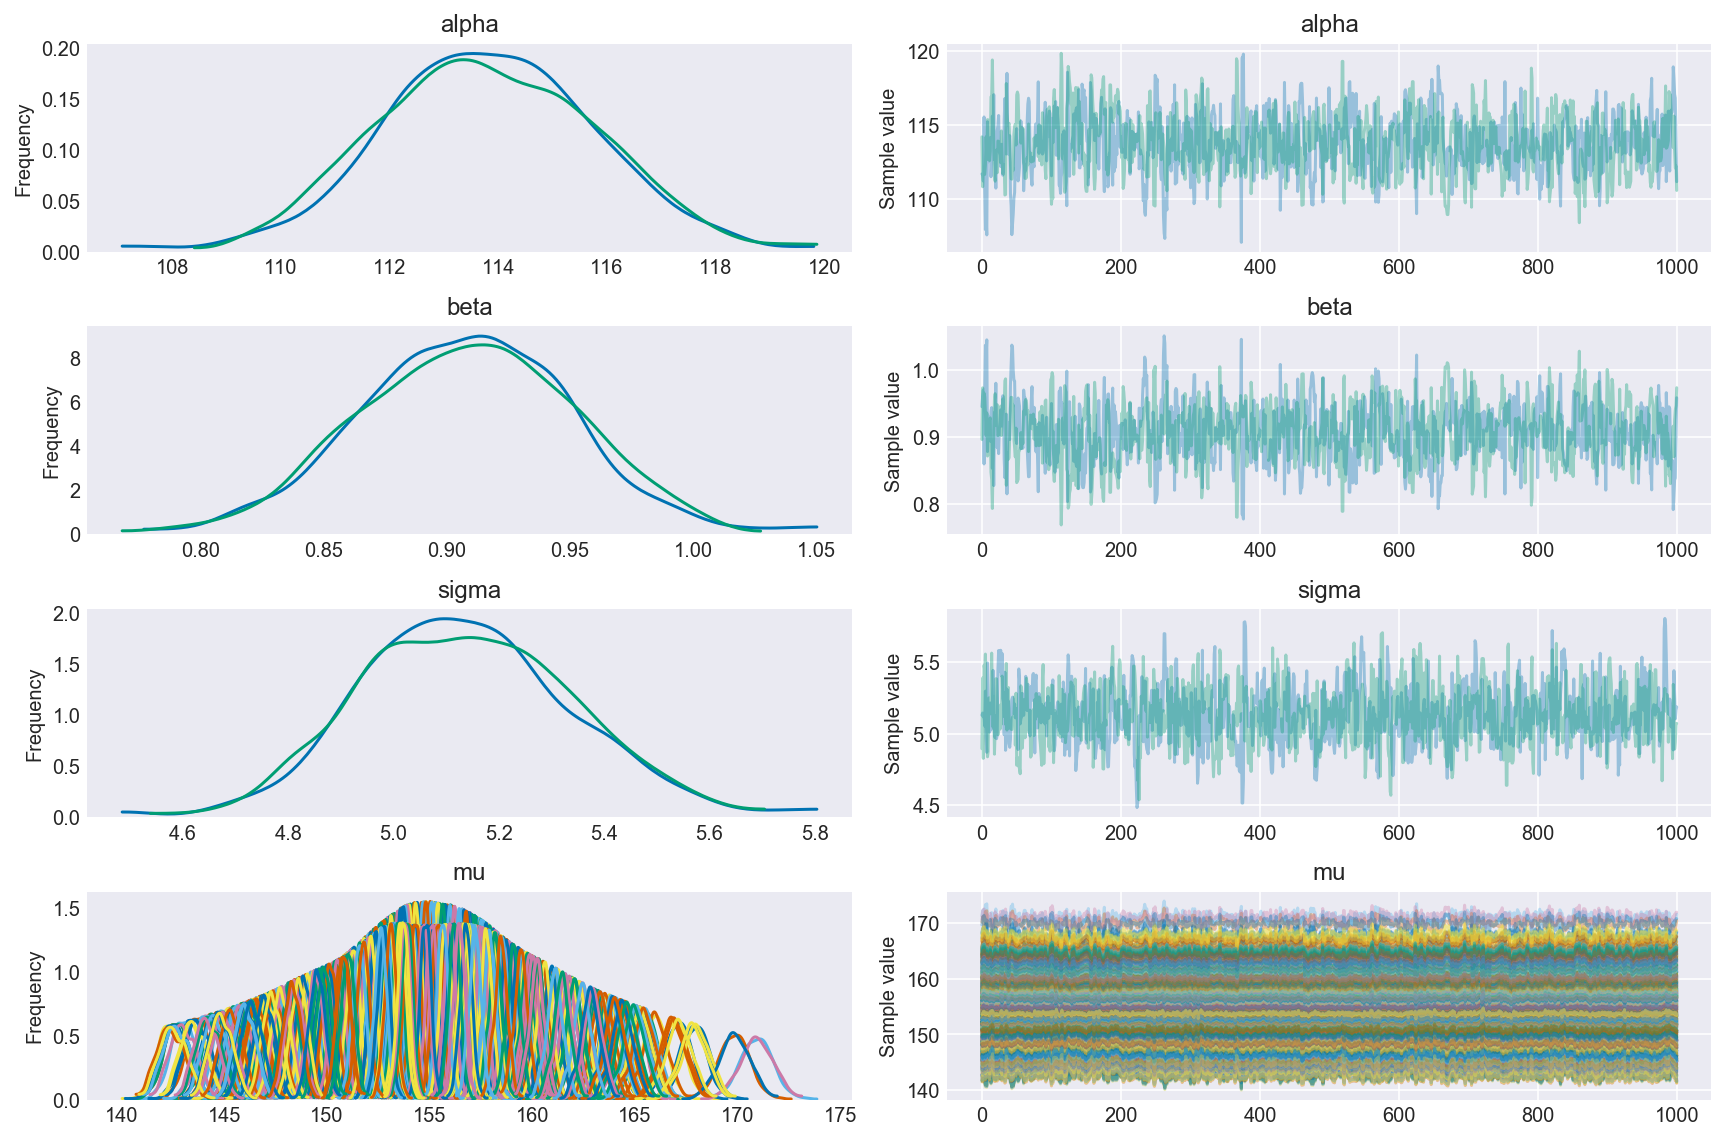

In [138]:
pm.traceplot(trace_4_3);

**4.40**

In [150]:
pm.summary(trace_4_3).head(7).round(3)

mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff   Rhat
alpha  113.783  1.975     0.075  110.306   117.945   697.938  1.000
beta     0.907  0.043     0.002    0.823     0.993   683.473  1.000
sigma    5.135  0.201     0.007    4.768     5.539   896.134  1.000
mu__0  157.168  0.290     0.007  156.632   157.780  1429.781  0.999
mu__1  146.881  0.466     0.016  146.005   147.803   850.598  1.000
mu__2  142.689  0.639     0.023  141.547   143.960   780.208  1.000
mu__3  161.899  0.429     0.014  161.021   162.725   872.459  1.000

In [148]:
# The mean average of μ
trace_4_3['mu'].mean()

154.64561325871279

Summary:
* β- for every 1 kg, a person is expected to be 0.9cm taller.  
* μ- the average height is 154.64cm
* σ- 95% of plausible heights lie within 10.2cm (2σ) of the mean height.
* α- a person of weight 0 should be 113cm tall. This is nonesense in real world terms, yet true in distribution terms. As a result, the intercept is often uninterpretable. **This is why we need very weak priors for intercepts.**

**4.41**
* Correlation

In [162]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df[['alpha','beta','sigma']].corr().round(2)

alpha  beta  sigma
alpha   1.00 -0.99  -0.04
beta   -0.99  1.00   0.04
sigma  -0.04  0.04   1.00

Notice how beta and alpha are perfectly negatively correlated (as the slope of the line changes, the intercept changes as well). Right now it's harmless, **but in more complex models, strong correlations make it difficult to fit the model to the data.** To eliminate this correlation we can use Centering.

# Centering
**4.42**

Centering is the procedure of subtracting the mean of a variable from each value. Let's center the weights.

In [6]:
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))
print("The average mean of all centered weights is equal to zero:")
print(round(pd.Series(d2.weight - d2.weight.mean()).mean(),5))
print("Let's use this list of centered weights in the model and see its affect.")

The average mean of all centered weights is equal to zero:
0.0
Let's use this list of centered weights in the model and see its affect.


**4.43**

In [7]:
with pm.Model() as m4_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c     # using the centered weights as opposed to uncentered reported weights 
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, beta, alpha]


**4.44**

In [8]:
pm.summary(trace_4_4, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
alpha  154.65  0.27       0.0   154.22    155.09  3153.94   1.0
beta     0.91  0.04       0.0     0.84      0.98  3133.01   1.0
sigma    5.15  0.19       0.0     4.84      5.43  2822.72   1.0

In [191]:
trace_df2 = pm.trace_to_dataframe(trace_4_4)
trace_df2.corr().round(2)

alpha  beta  sigma
alpha   1.00  0.00   0.01
beta    0.00  1.00  -0.03
sigma   0.01 -0.03   1.00

After centering, we see that there is no correlation anymore between alpha and beta, which will be good for complex models. 

**If intercept means that when predictor=0 a person is 154cm tall, and - given centering - The average predictor is equal to zero; then we can conclude that when the predictor (weight) is at its average value the outcome (height) is at its average value as well.**

This means a more predictabel intercept.

# Plotting the Posterior Regression (adding uncertainty around the mean)
**4.45**

(Instead of using the MAP like in the book, we are going to use the mean of the posterior)

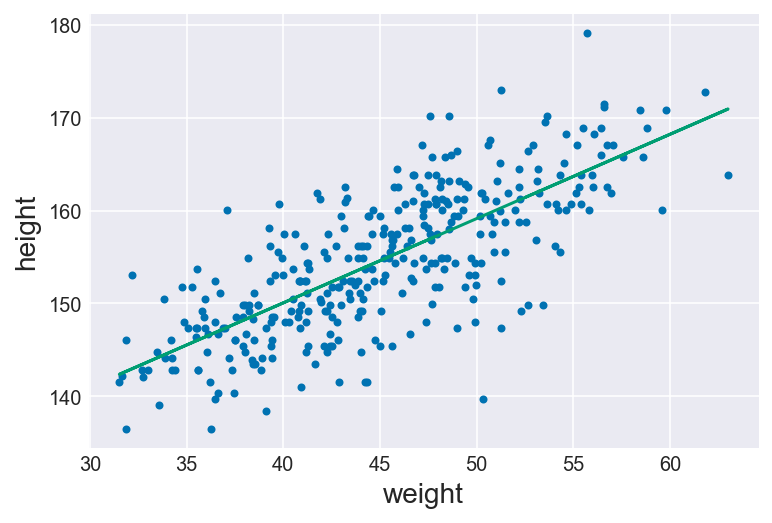

In [213]:
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_4['alpha'].mean() + trace_4_4['beta'].mean() * d2.weight_c)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

**4.46, 4.47**

In [223]:
print("Every combination of alpha and beta define a line.")
pm.trace_to_dataframe(trace_4_4)[:5]

Every combination of alpha and beta define a line.


alpha      beta     sigma
0  154.504198  0.848980  5.063707
1  154.912213  0.865988  5.190649
2  154.704215  0.869236  4.855041
3  154.677874  0.857822  4.860037
4  154.427690  0.829234  5.128142

**4.48, 4.49**
* adding uncertainty around the mean

In [10]:
"""First we'll compute the posterior with the first 10 data points only, N=10"""

N = [10, 50, 150, 352][0]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, beta, alpha]
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4333366608680737, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


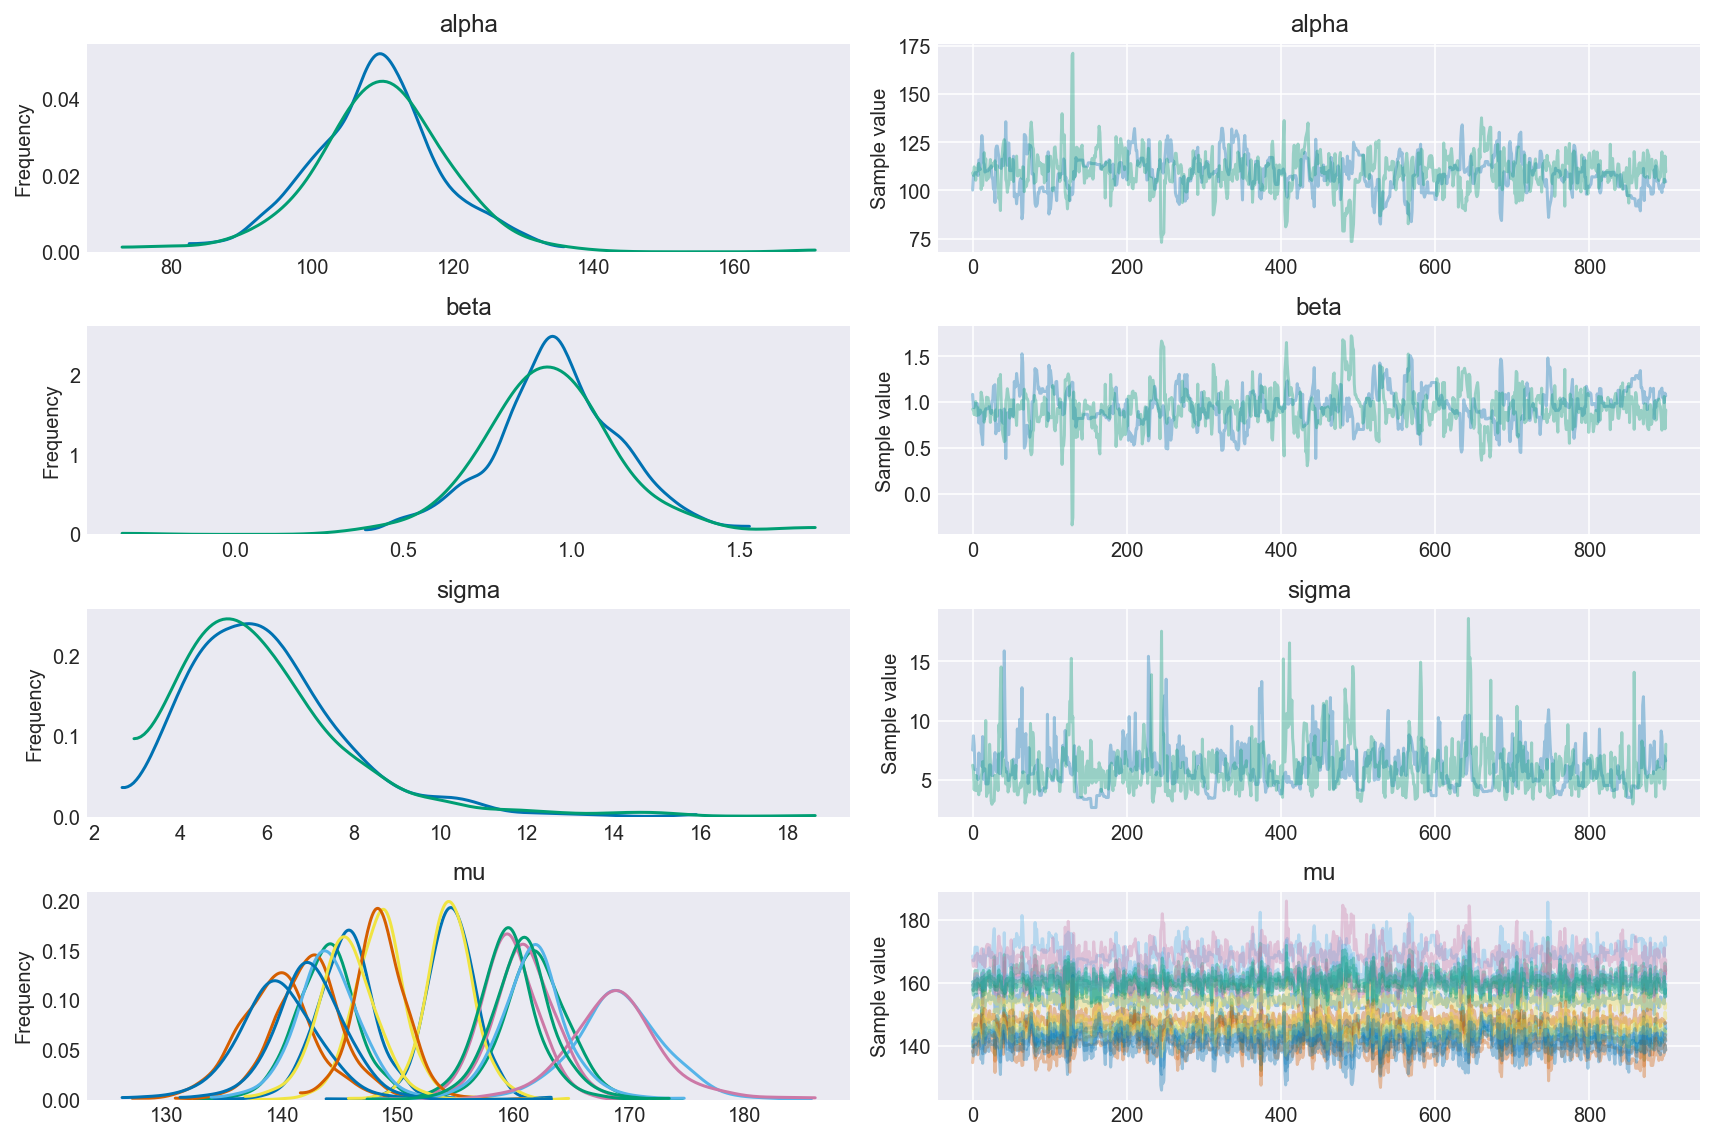

In [11]:
"""The model has the first 10 data points only"""
chain_N = trace_N[100:]
pm.traceplot(chain_N);

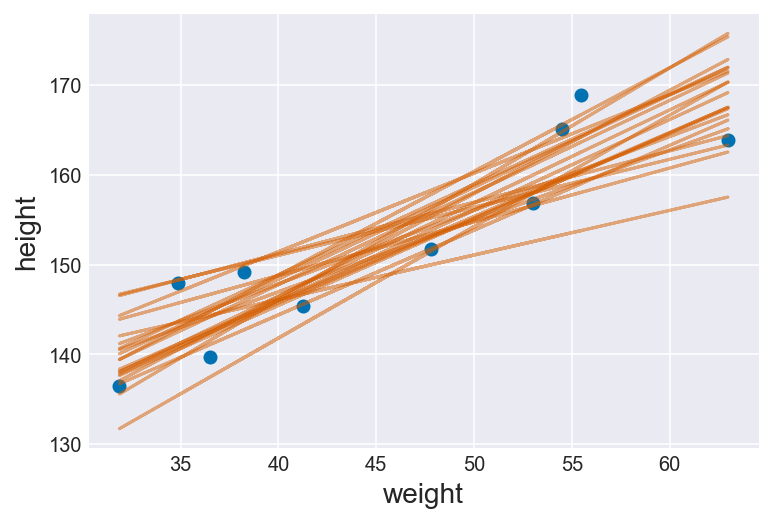

In [12]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * d2.weight[:N], 'C2-', alpha=0.5)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

In [3]:
"""Now compute the posterior with the first 150 data points, N=150"""

N = [10, 50, 150, 352][2]
with pm.Model() as m_N2:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N2 = pm.sample(1000, tune=1000)

NameError: name 'd2' is not defined

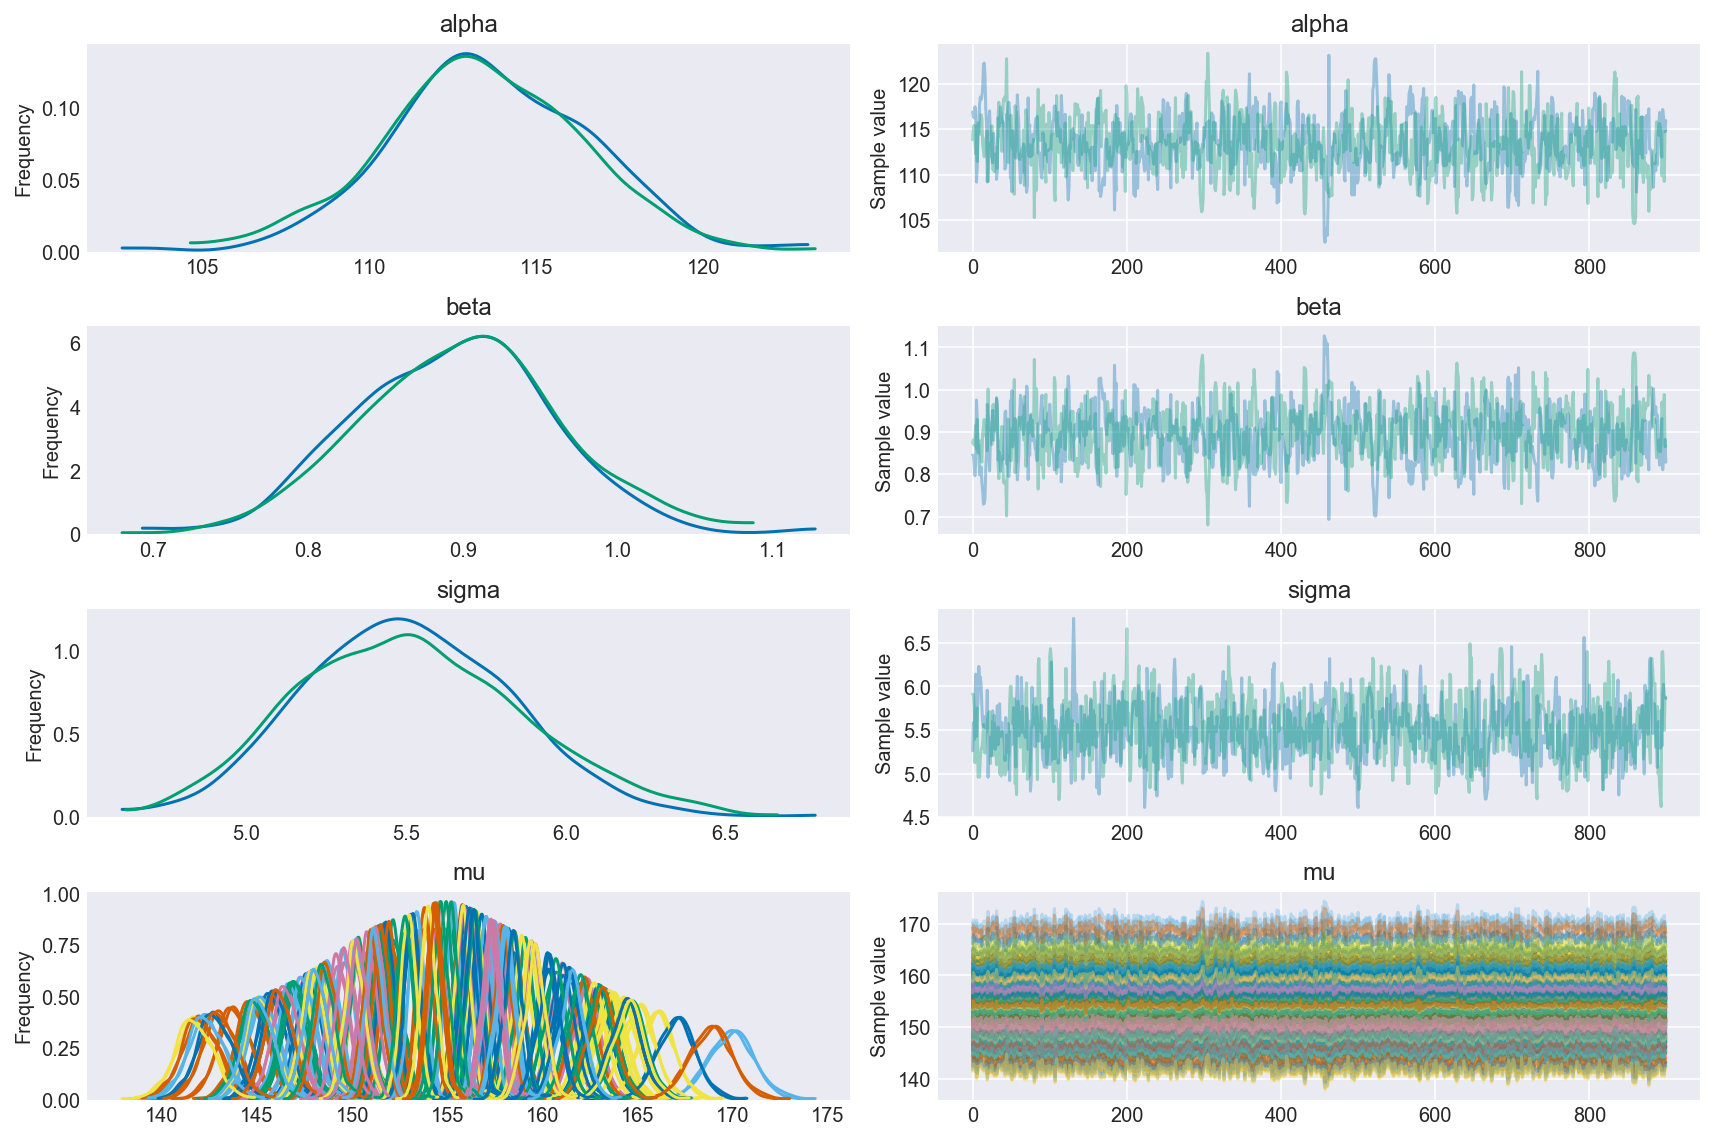

In [220]:
"""The model has 150 data points"""

chain_N2 = trace_N2[100:]
pm.traceplot(chain_N2);

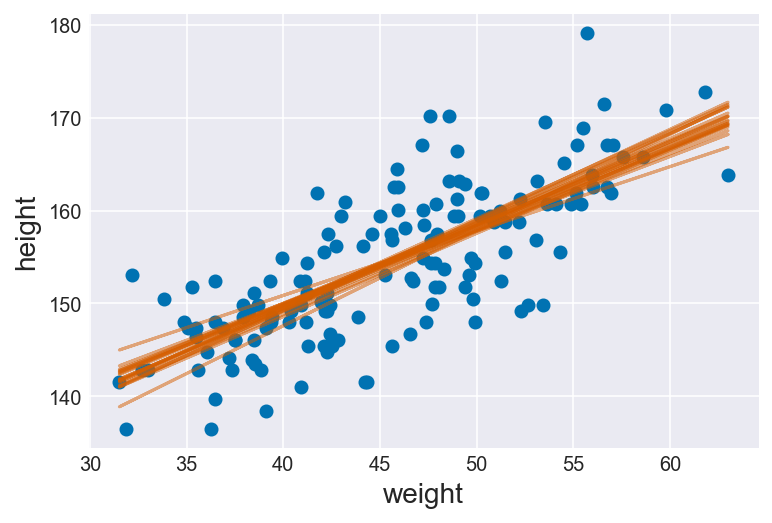

In [225]:
"""The model has 150 data points as opposed to 10"""

plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N2))
    plt.plot(d2.weight[:N], chain_N2['alpha'][idx] + chain_N2['beta'][idx] * d2.weight[:N], 'C2-', alpha=0.5)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

Comparing 10 to 150 data points, it's visible that the regression lines become more compact as the model grows more confident about the location of the mean. We also see more uncertainty at the extreme values  for weight.

**4.50, 4.51**
* Plotting regression intervals

In [ ]:
N = [10, 50, 150, 352][0]

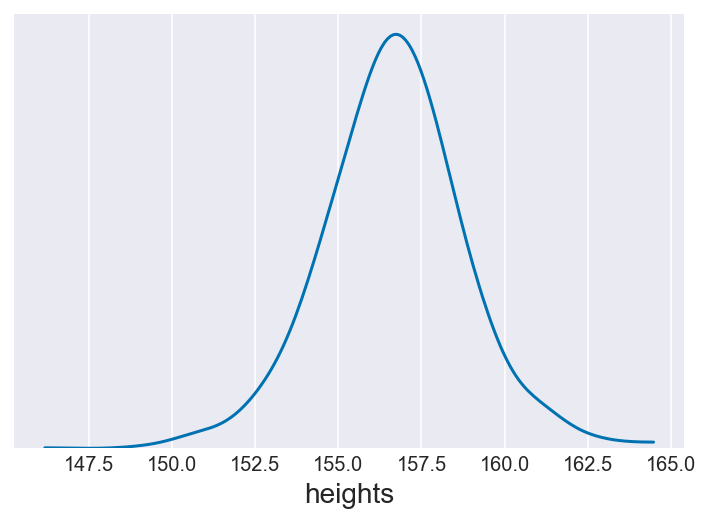

In [270]:
"""Plotting distribution of height for 50kg, with the model that used 10 data points."""
# since alpha and beta are of a normal distribution, the distribution of mu will also be Normal

mu_at_50 = chain_N['alpha'] + chain_N['beta'] * 50
pm.kdeplot(mu_at_50)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

**4.52**

In [271]:
pm.hpd(mu_at_50, alpha=.11)

array([153.43938992, 160.08112646])

**For 50kg the heights range from 153 to 160cm. Now we have to compute the same thing for each weight unit.**

**4.53**

(Using PyMC3, we do not need to compute anything else. By defining a deterministic variable mu in the model, we add that variable to the trace. Thus, we get a matrix with row samples from the posterior and columns values of weights. We can access this matrix directly from the trace or turn it into a DataFrame, it all depends on what we need).

In [281]:
df_trace_N = pm.trace_to_dataframe(chain_N).filter(regex=('mu.*'))
# df_trace_N.head()

**4.54 and 4.58**
* plotting the uncertainty of the posterior for weights between 25-71

(We are doing manually, what in thebook is done using the link function. In the book on code 4.58 the following operations are performed manually).

In [22]:
weigth_seq  = np.arange(25, 71) # using 46 values to define range
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = chain_N[::10] # using chain_N which has 10 data points. Remember, chain_N2 has 150 data points
mu_pred = np.zeros((len(weigth_seq), len(chain_N_thinned)*chain_N.nchains))
for i, w in enumerate(weigth_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

**4.55**

We fed mu 46 different values for weight. To visualize this let's plot the distribution of mu at each height.

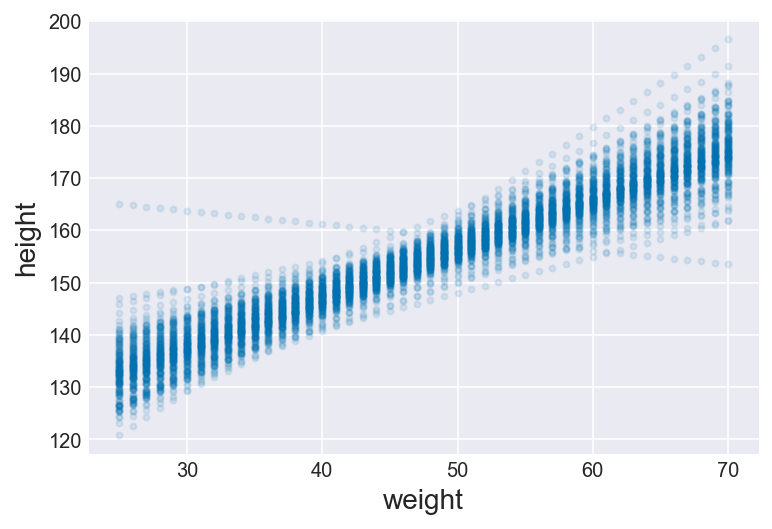

In [23]:
plt.plot(weigth_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

**4.56**

Summarize the distribution of heights for each weight value

In [24]:
mu_mean = mu_pred.mean(1) #now mu_mean contains the avg mu at each weight value.
mu_hpd = pm.hpd(mu_pred.T, alpha=.11) # with an 89% predicted height interval

**4.57**

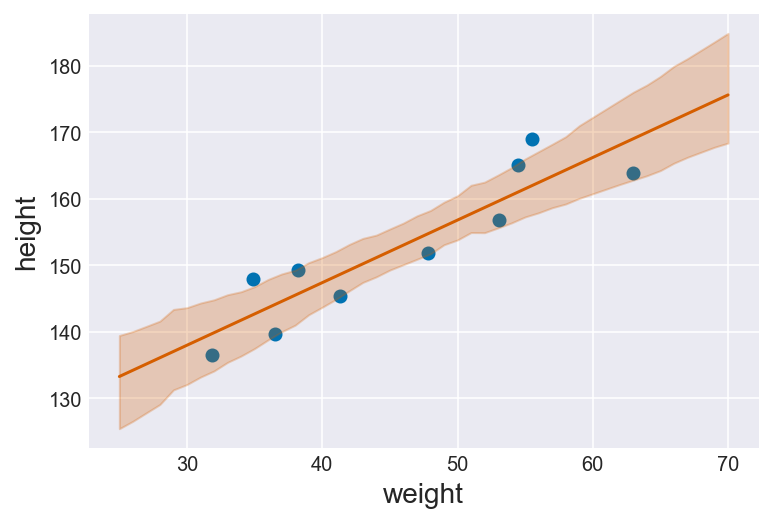

In [25]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weigth_seq, mu_mean, 'C2')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);
# plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

# Prediction Intervals
In the predictions above, we used only the uncertainty of the mean (mu) to predict values.
$$μ_i = α+βx_i$$

But the predition of heights depends also upon the stochastic definition of the Gaussian likelihood:
$$h_i \sim Normal(μ,σ)$$

So below, we'll incorporate the standard deviation (σ) and its uncertainty as well into the predicted values. 

We are going to use sample_ppc() from PyCM3. This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)

**4.59**

In [47]:
height_pred = pm.sample_ppc(chain_N, 100, m_N)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1599.94it/s]


**4.60**

In [48]:
height_pred_hpd = pm.hpd(height_pred['height_hat'], alpha=0.11) #89% HPDIinterval

**4.61**

(sample_ppc returns values corresponding to the input values (weights in this example). Because the weights are not ordered if we use them with the fill_between function we will get a mess. For that reason in the following cell we order the weights and the predicted heights. **Another solution is to order the predictor (weight) before building the model.**)

In [49]:
idx = np.argsort(d2.weight.values[:N])
d2_weight_ord = d2.weight.values[:N][idx]
height_pred_hpd = height_pred_hpd[idx]

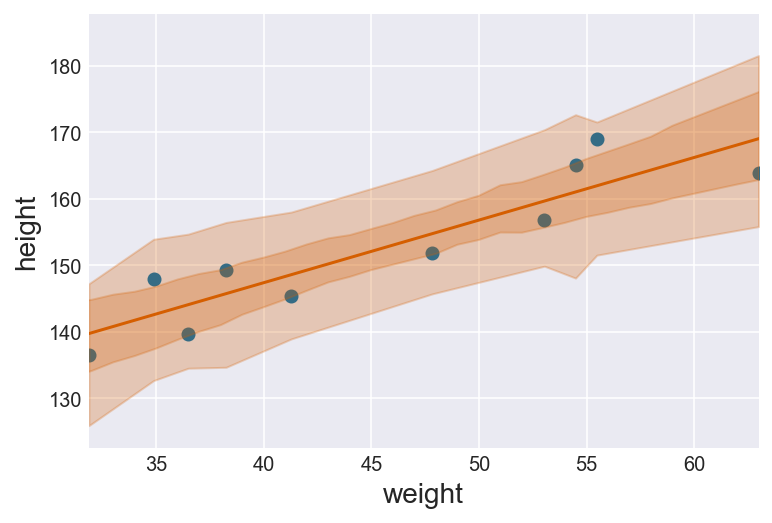

In [50]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(d2_weight_ord, height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)
plt.plot(weigth_seq, mu_mean, 'C2')
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

**Important**

* The solid line is the estimate of the mean height at each weight. 
* The narrow shaded region is the distribution of μ, and it ilustrates the 89% interval around the line.
* The wider shaded region represents the region within which the model expects to find 89% of actual heights in the population, at each weight.

**4.62**

(Change the number of samples used in 4.59 (100) to other values. Because we are getting samples at the input values the jaggedness of this plot is larger than the one in the book. You will see that with 200 or more samples the shaded boundary smooothes out a little.)

**4.63**

**Now we are going to generate heights from the posterior manually,** instead of restricting to the input values we are going to pass an array of equally spaced weights values weight_seg.

In [51]:
weigth_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000): # number of samples from the posterior
    i = np.random.randint(len(chain_N))
    mu_pred = chain_N['alpha'][i] + chain_N['beta'][i] * weigth_seq
    sigma_pred = chain_N['sigma'][i]
    post_samples.append(np.random.normal(mu_pred, sigma_pred))

In [52]:
post_samples_hpd = pm.hpd(np.array(post_samples))

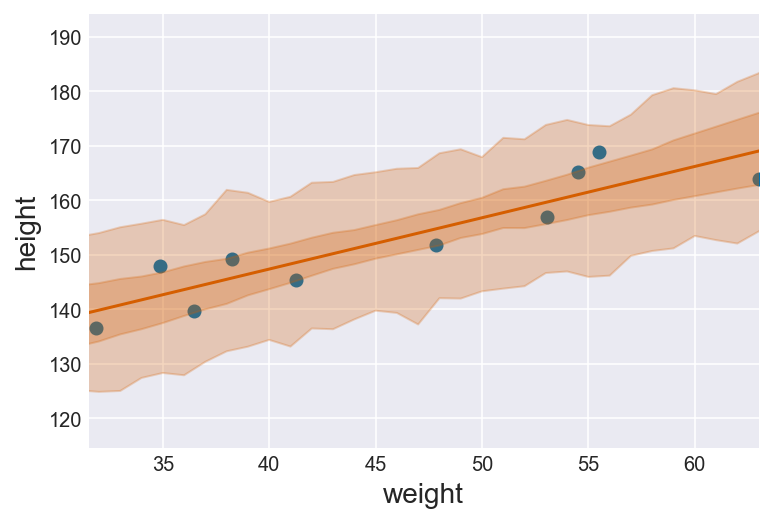

In [54]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weigth_seq, mu_mean, 'C2')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(weigth_seq, post_samples_hpd[:,0], post_samples_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight.min(), d2.weight.max());

# Polynomial Regression


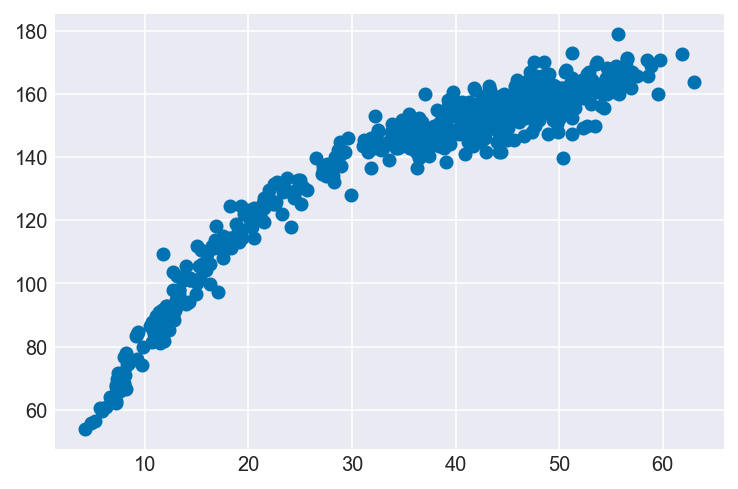

In [62]:
plt.scatter(d.weight, d.height);

The relationship between height and weight is visibly curved. One way to model a curved relationship is polynomial regression. In this context "polynomial" means equations for μ_i that add additional terns with squares, cubes, and even higher powers on the predictor variable. There is still only one predictor variable, so this is still a bivariate regression. But the definition of μ_i has more parameters now.
$$μ = α + β_1x_i + β_2x_i^2$$

where x sqaured is used to construct the parabula, and `β_2` measures the curvature of the relationship.

**Warning!**

The above is a parabolic (second order) polynomial, which is one way to constrcut a polynomial regression. As you add more non-linear terms, the fit should improve in general, at least on the training data. However, this is not an indication that you have found a better model. A polynomial regression is generally a bad idea, because polynomials are very hard to interpret and they tend to overfit the data when sample size is small. Sometimes, using the logarithm of the predictor is better (see Ch.4 exercises, 4h3.).

**4.64**

We have already loaded this dataset earlier.

In [59]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

First, we will standardize the predictor variable. Standardizing helps because it makes interpretation easier. For a standardized variable, a change in one unit is equivalent to a change of one standard deviation.

**4.65**

In [71]:
d.weight_std = (d.weight - d.weight.mean()) / d.weight.std()

The standardized weight variable has mean=0 and std=1. No information has changed, just the x axis has a different range

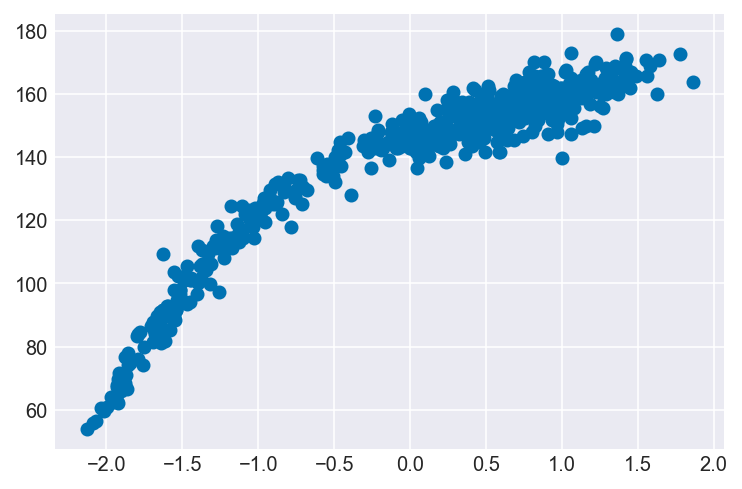

In [74]:
plt.scatter(d.weight_std, d.height);

Model definition:
\begin{aligned}
h_i &\sim Normal(μ_i,σ)\\
μ_i &= α + β_1x_i + β_2x_i^2\\
α &\sim Normal(178,100)\\
β_1 &\sim Normal(0,10)\\
β_2 &\sim Normal(0,10)\\
σ &\sim Uniform(0,50)
\end{aligned}

To create the quadratic term (x^2), it is better to pre-process it outside the model:

In [76]:
d.weight_std2 = d.weight_std**2

**4.66**

In [77]:
with pm.Model() as m_4_5:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_std + beta[1] * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, beta, alpha]


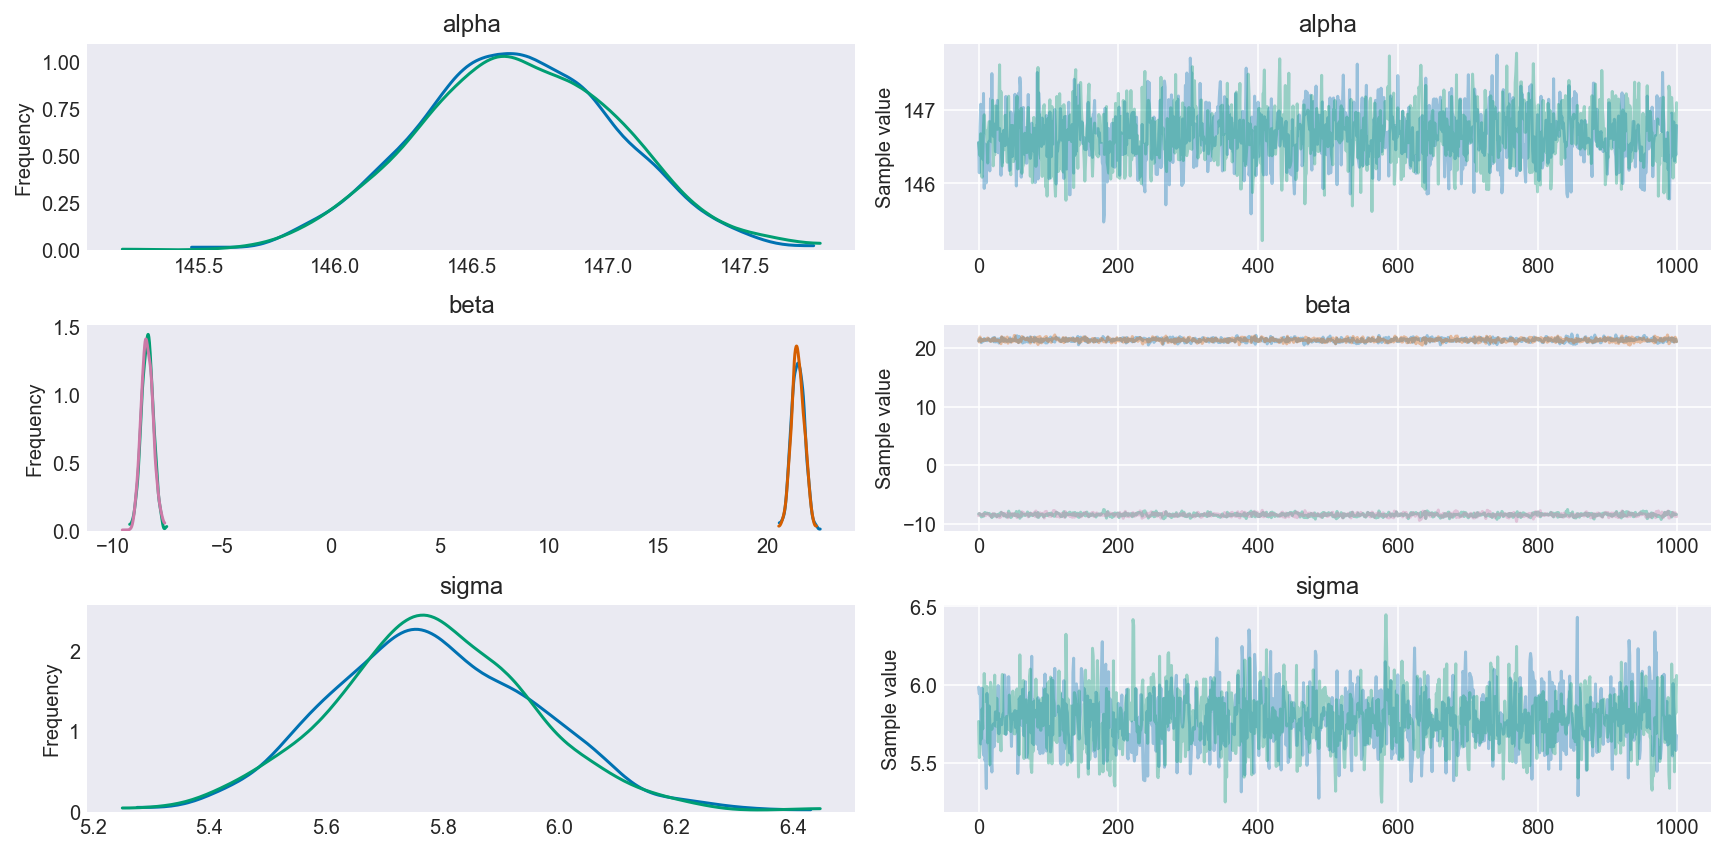

In [78]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace_4_5, varnames);

**4.67**

In [79]:
pm.summary(trace_4_5, varnames, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
alpha    146.66  0.36      0.01   146.09    147.23  1271.00   1.0
beta__0   21.39  0.29      0.01    20.96     21.89  1629.30   1.0
beta__1   -8.42  0.27      0.01    -8.81     -7.96  1307.97   1.0
sigma      5.78  0.17      0.00     5.52      6.06  1398.96   1.0

**4.68**

In [80]:
mu_pred = trace_4_5['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_ppc(trace_4_5, 200, m_4_5)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1066.68it/s]


**4.69**

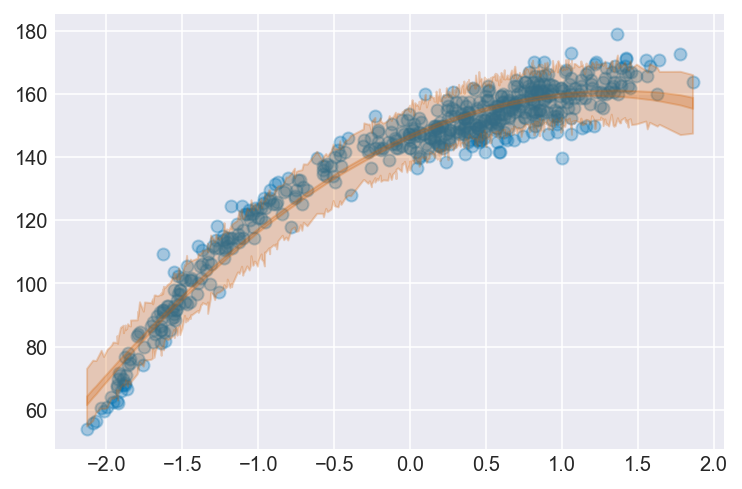

In [81]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25);

* alpha: when log weight is zero the expected value of height is 146.6
* beta 1 & 2: are the linear and square components of the curve, but they are hard to interpret

**4.70**

Let's use the cubic regression (a higher-order polynomial regression) on weight to see the difference:
$$μ = α + β_1x_i + β_2x_i^2 + β_3x_i^3$$

(In pymc3, we will stack the weights to get a 2D array, these simplifies wrriting a model. Now we can compute the dot product between beta and the 2D-array.)

In [83]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

In [84]:
with pm.Model() as m_4_6:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, beta, alpha]


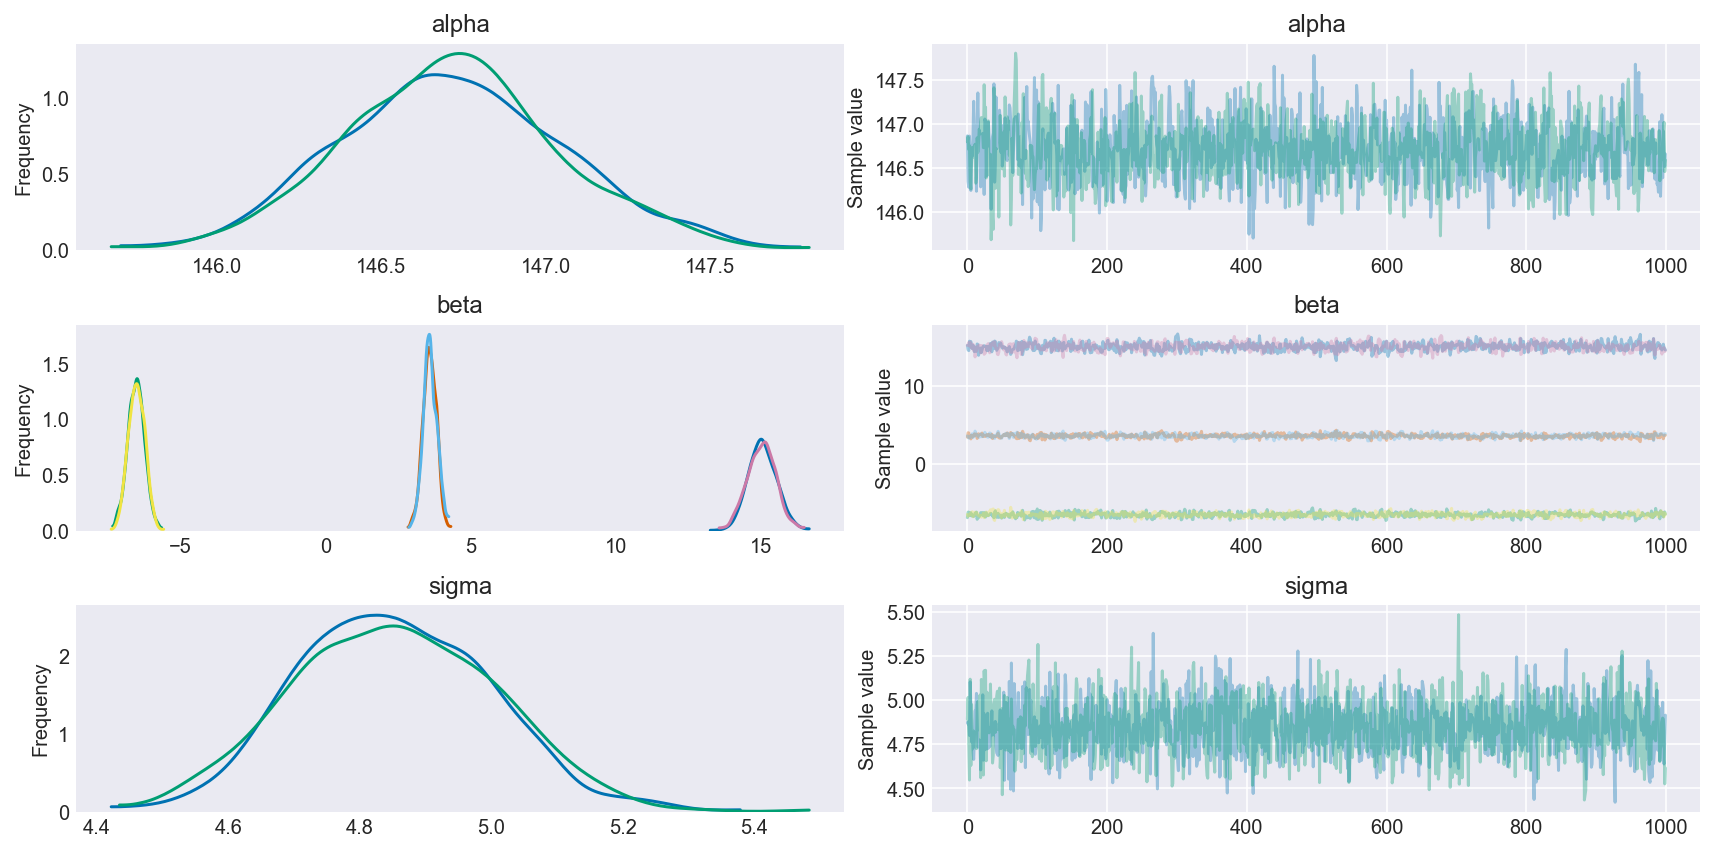

In [85]:
pm.traceplot(trace_4_6, varnames);

In [92]:
mu_pred = trace_4_6['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_ppc(trace_4_6, 200, m_4_6)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1025.41it/s]


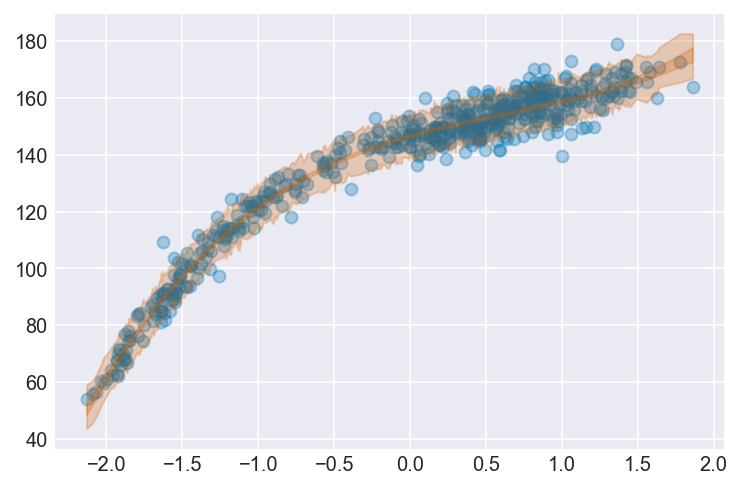

In [93]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25);

The 89% HPD Interval for predicted heights (orange) represents the region within which the model expects to find 97% of actual heights in the population, at each weight.

**Note:**

We see that the model above fits the data better, but this good geocentric description of the samples doesn't necessarily mean a better model. 

**4.71, 4.72**

* Converting the x axis back to natural scale

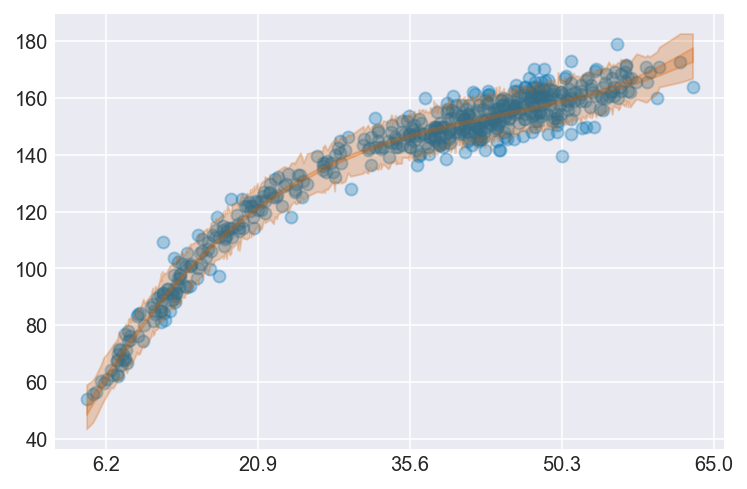

In [94]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

In [82]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 \
%s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), 
                                                       sys.version[:5], IPython.__version__, pm.__version__, 
                                                       np.__version__, pd.__version__, scipy.__version__, 
                                                       matplotlib.__version__))

This notebook was createad on a computer AMD64 running   and using:
Python 3.6.4
IPython 6.2.1
PyMC3 3.4.1
NumPy 1.14.0
Pandas 0.22.0
SciPy 1.0.0
Matplotlib 2.1.2

